In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import tensorflow_datasets as tfds

In [2]:
# Step 1: Load the Stanford Dogs dataset
(train_data, test_data), info = tfds.load('stanford_dogs', split=['train', 'test'],
                                          with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.S4BGYC_0.2.0/stanford_dogs-train.tfrecord*...:   …

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.S4BGYC_0.2.0/stanford_dogs-test.tfrecord*...:   0…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [5]:
# Step 2: Preprocess the data (Resize, Normalize and Data Aguemntation)
IMG_SIZE = (224, 224)

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)  # Resize images to 224x224
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label


def preprocess_with_augmentation(image, label):
    image = tf.image.resize(image, IMG_SIZE)  # Resize images to 224x224
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]

    # Data Augmentation
    image = tf.image.random_flip_left_right(image)  # Random horizontal flip
    image = tf.image.random_brightness(image, max_delta=0.1)  # Random brightness adjustment
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Random contrast adjustment

    return image, label

train_data = train_data.map(preprocess_with_augmentation).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.map(preprocess).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Check the shape of a batch of data (to ensure correct processing)
for image_batch, label_batch in train_data.take(1):
    print(f'Image batch shape: {image_batch.shape}')
    print(f'Label batch shape: {label_batch.shape}')

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


In [6]:
# Step 3: Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [7]:
# Step 4: Add Custom Classification Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(120, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
# Step 5: Compile and Train the Model (Freeze Base Layers)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.001),  # Higher learning rate for dense layers
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/best_model.keras', save_best_only=True, monitor='val_accuracy')
]

# Train only the top layers
initial_history = model.fit(train_data,
                            epochs=10,  # Train for longer
                            validation_data=test_data,
                            callbacks=callbacks)


Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 81s 178ms/step - accuracy: 0.0080 - loss: 4.8598 - val_accuracy: 0.0057 - val_loss: 4.7869 - learning_rate: 0.0010
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 157ms/step - accuracy: 0.0056 - loss: 4.7882 - val_accuracy: 0.0063 - val_loss: 4.7875 - learning_rate: 0.0010
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 76s 203ms/step - accuracy: 0.0080 - loss: 4.7886 - val_accuracy: 0.0059 - val_loss: 4.7875 - learning_rate: 0.0010
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 156ms/step - accuracy: 0.0060 - loss: 4.7882 - val_accuracy: 0.0059 - val_loss: 4.7874 - learning_rate: 0.0010
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 101s 206ms/step - accuracy: 0.0073 - loss: 4.7865 - val_accuracy: 0.0085 - val_loss: 4.7827 - learning_rate: 2.0000e-04
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 157ms/step - accuracy: 0.0100 - loss: 4.7826 - val_accuracy: 0.0085 - val_loss: 4.7801 - learning_rate: 2.0000e-04
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 158ms/step - accu

In [14]:
# Step 7: Evaluate the Model
loss, accuracy = model.evaluate(test_data)
print(f"Validation Accuracy before Fine-Tuning: {accuracy * 100:.2f}%")

269/269 ━━━━━━━━━━━━━━━━━━━━ 30s 98ms/step - accuracy: 0.0082 - loss: 4.7810
Validation Accuracy before Fine-Tuning: 0.92%


In [15]:
# Step 6: Fine-Tune the Model
# Unfreeze the top layers of the base model
for layer in base_model.layers[-30:]:  # Unfreeze the last 30 layers
    layer.trainable = True

# Recompile with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the entire model
fine_tune_history = model.fit(train_data,
                              epochs=15,  # Fine-tune for more epochs
                              validation_data=test_data,
                              callbacks=callbacks)

Epoch 1/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 94s 202ms/step - accuracy: 0.0103 - loss: 4.7737 - val_accuracy: 0.0112 - val_loss: 4.7603 - learning_rate: 1.0000e-04
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 72s 191ms/step - accuracy: 0.0102 - loss: 4.7668 - val_accuracy: 0.0160 - val_loss: 4.7726 - learning_rate: 1.0000e-04
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 98s 235ms/step - accuracy: 0.0141 - loss: 4.7563 - val_accuracy: 0.0112 - val_loss: 4.7546 - learning_rate: 1.0000e-04
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 70s 187ms/step - accuracy: 0.0112 - loss: 4.7519 - val_accuracy: 0.0122 - val_loss: 4.7465 - learning_rate: 1.0000e-04
Epoch 5/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 187ms/step - accuracy: 0.0130 - loss: 4.7430 - val_accuracy: 0.0101 - val_loss: 4.7682 - learning_rate: 1.0000e-04
Epoch 6/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 72s 191ms/step - accuracy: 0.0174 - loss: 4.7401 - val_accuracy: 0.0170 - val_loss: 4.7249 - learning_rate: 1.0000e-04
Epoch 7/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 88s 23

In [16]:
# Step 7: Evaluate the Model
loss, accuracy = model.evaluate(test_data)
print(f"Validation Accuracy after Fine-Tuning: {accuracy * 100:.2f}%")

269/269 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - accuracy: 0.0379 - loss: 4.5083
Validation Accuracy after Fine-Tuning: 3.58%


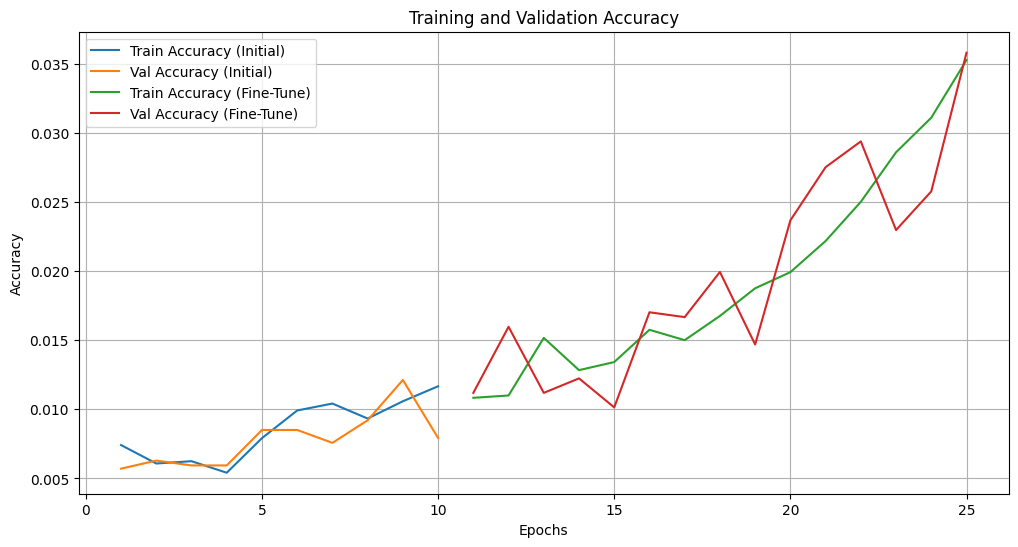

In [17]:
# Step 8: Plot Training History
import matplotlib.pyplot as plt

def plot_history(initial_history, fine_tune_history):
    plt.figure(figsize=(12, 6))
    epochs_initial = range(1, len(initial_history.history['accuracy']) + 1)
    epochs_fine_tune = range(len(initial_history.history['accuracy']) + 1,
                             len(initial_history.history['accuracy']) + len(fine_tune_history.history['accuracy']) + 1)

    # Plot training and validation accuracy
    plt.plot(epochs_initial, initial_history.history['accuracy'], label='Train Accuracy (Initial)')
    plt.plot(epochs_initial, initial_history.history['val_accuracy'], label='Val Accuracy (Initial)')
    plt.plot(epochs_fine_tune, fine_tune_history.history['accuracy'], label='Train Accuracy (Fine-Tune)')
    plt.plot(epochs_fine_tune, fine_tune_history.history['val_accuracy'], label='Val Accuracy (Fine-Tune)')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(initial_history, fine_tune_history)